# Correlation Between Samples

In [1]:
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme(
    context="paper", 
    style="whitegrid", 
    font_scale=1.2,
    rc={'figure.figsize': (10, 10), 'figure.dpi': 300}
)

## Get Data

In [83]:
from common.data import get_data
from common.paths import HEALTHY, ADHD
from sklearn.preprocessing import StandardScaler

X, _, demographics, population = get_data(wisc_level=5, label_path=ADHD)
ages = demographics['Age']

X = StandardScaler().fit_transform(X)

print(f'X: {X.shape} | Age: {ages.shape} | Population: {population}')

X: (373, 34716) | Age: (373,) | Population: adhd


In [82]:
from common.data import filter_data_by_network
from common.power_atlas import POWER_NETWORKS

X = filter_data_by_network(X, POWER_NETWORKS['CBR'], True)

print(X.shape)

(373, 15)


In [55]:
from common.binning import bin_data, ONLY_BIN_LABELS

X_bins, _, bin_labels = bin_data(X, ages, ages, False, 3)

for age_bin, bin_label in zip(X_bins, bin_labels):
    print(f'{bin_label}: {age_bin.shape}')

Bin 1: (114, 34716)
Bin 2: (147, 34716)
Bin 3: (112, 34716)


### Generate fake data

In [6]:
from common.data import generate_fake_data

X, y = generate_fake_data(X, y)

print(f'X: {X.shape}')

X: (373, 34716)


## Correlation

In [5]:
from scipy import stats
from sklearn.model_selection import LeaveOneOut

### Correlate every sample (all combinations)

In [11]:
%%time
correlations = []

for index, curr_subject in enumerate(X):
    for next_subject in X[index + 1:len(X) + 1]:
        correlations.append(stats.pearsonr(curr_subject, next_subject)[0])

print(f'Num correlations: {len(correlations)}')

Num correlations: 69378
CPU times: user 17min 47s, sys: 29.9 s, total: 18min 17s
Wall time: 2min


Text(0.5, 1.0, 'method=all, population=adhd, n=373, num_correlations=69378')

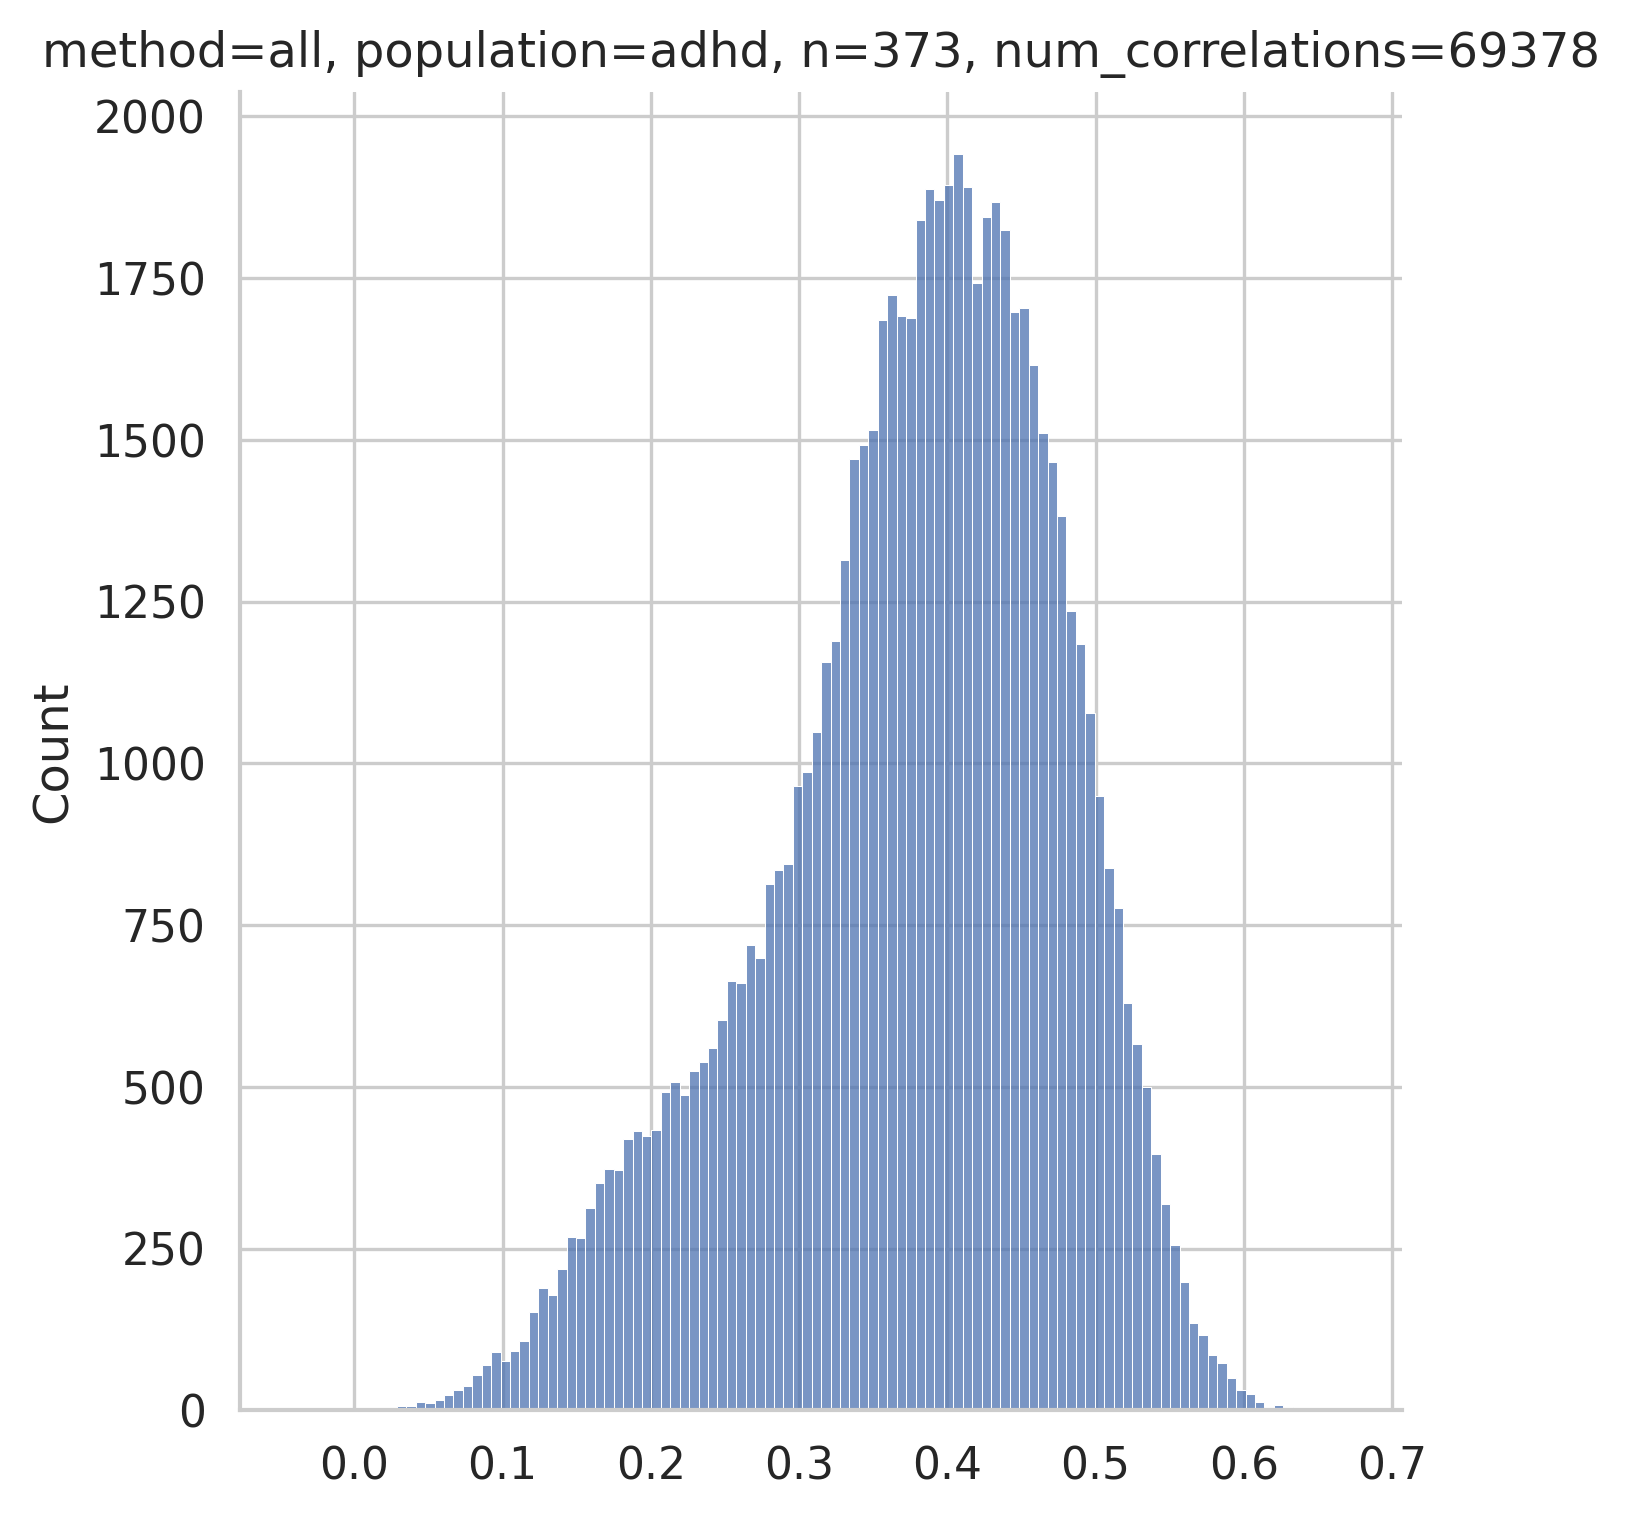

In [12]:
g = sns.displot(correlations)
g.ax.set_title(f'method=all, population={population}, n={len(X)}, num_correlations={len(correlations)}')

### Correlate every sample (leave-one-out)

In [18]:
X_loo = X_bins[0]
population = bin_labels[0]

correlations = []
bad_subjects = []
loo = LeaveOneOut()

for rest_subjects, curr_subject in loo.split(X_loo):
    X_curr, X_rest = X[curr_subject][0], X[rest_subjects]
    X_rest_mean = np.mean(X_rest, axis=0)
    r, p = stats.pearsonr(X_curr, X_rest_mean)
    correlations.append(r)

print(f'Num correlations: {len(correlations)}')

Num correlations: 114


Text(0.5, 1.0, 'method=loo, population=Bin 1, n=373, num_correlations=114')

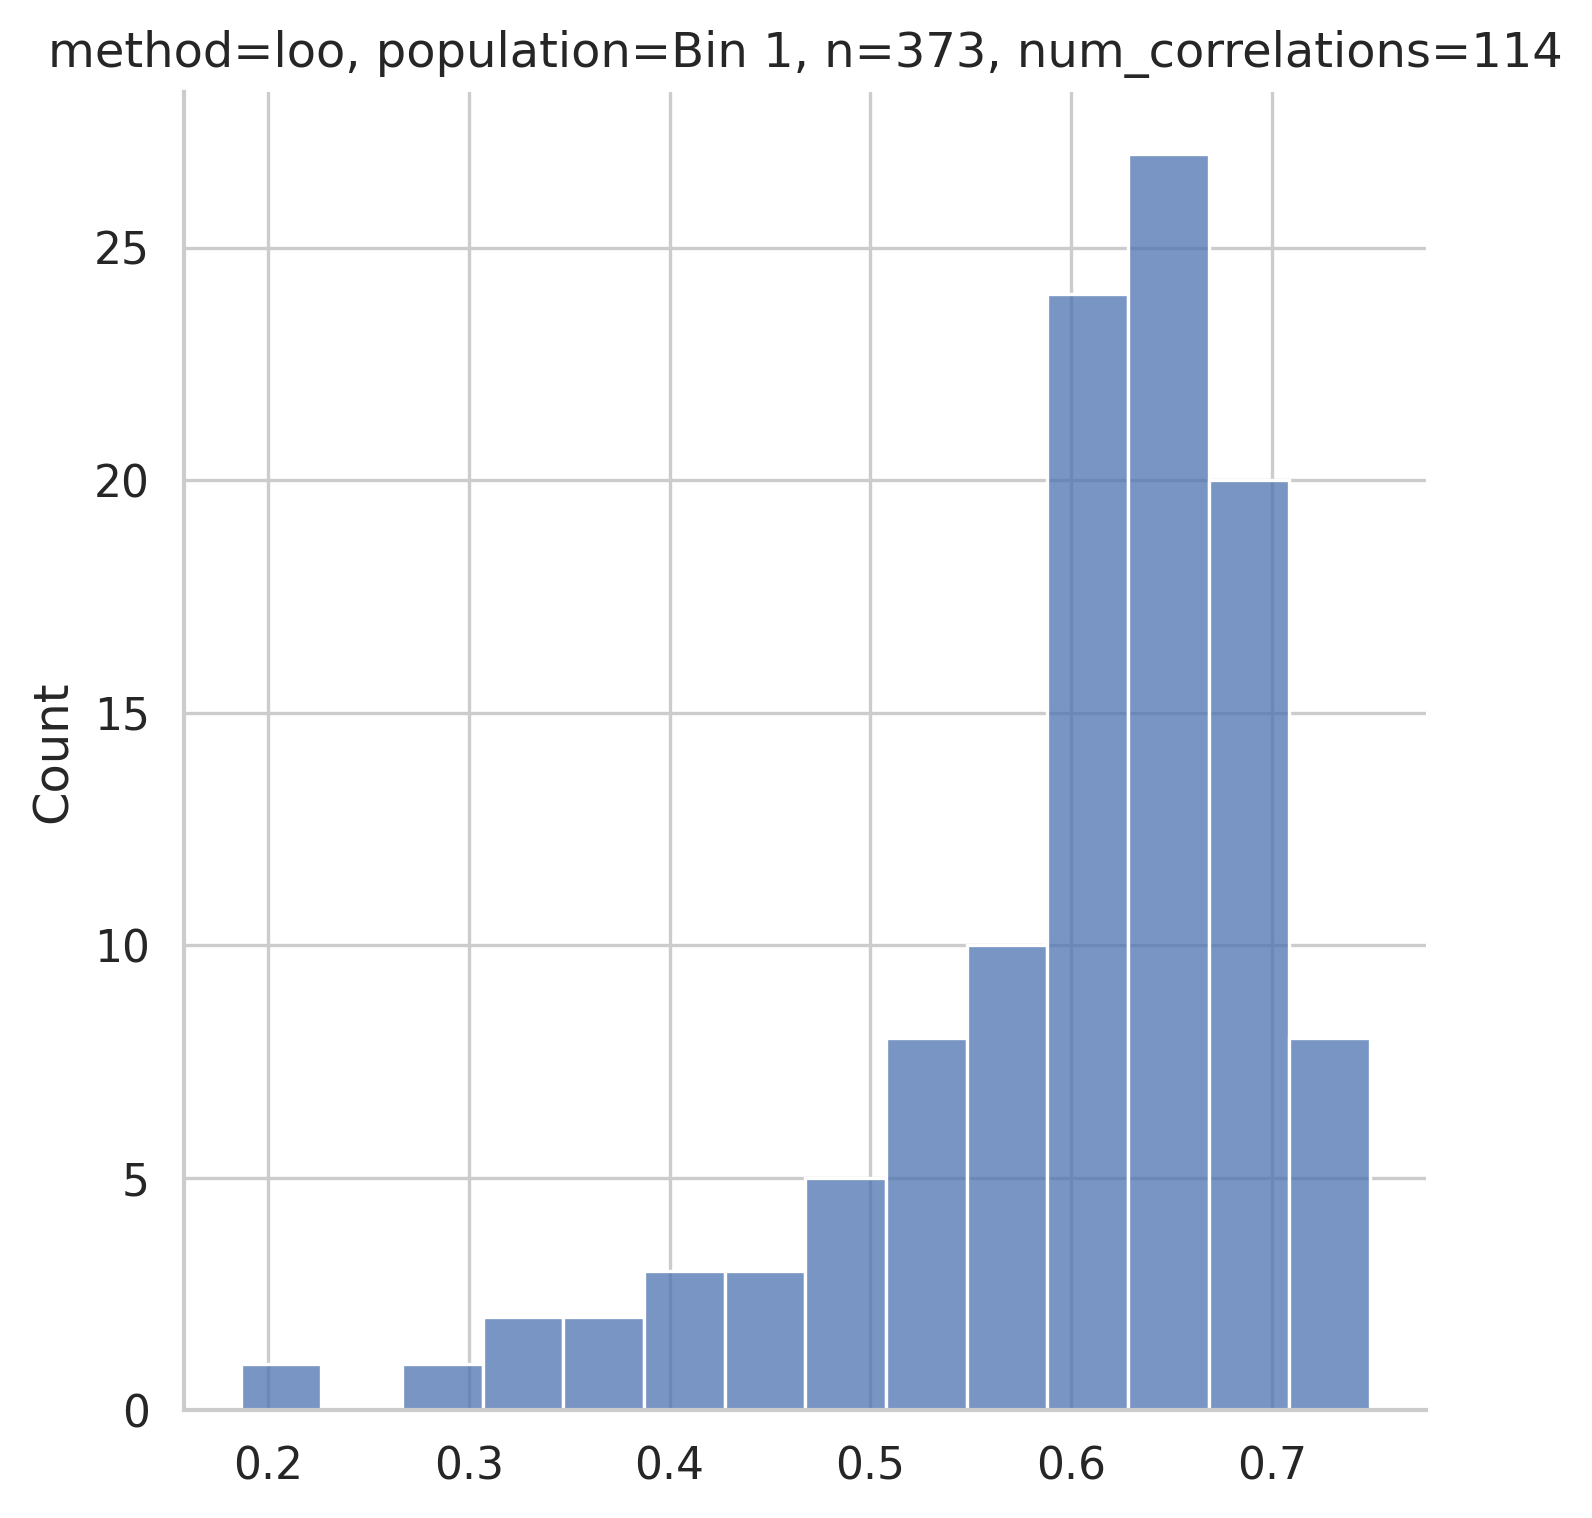

In [19]:
g = sns.displot(correlations)
g.ax.set_title(f'method=loo, population={population}, n={len(X)}, num_correlations={len(correlations)}')

## Cross Prediction Correlation

In [84]:
bin_means = [(np.mean(X_bin, axis=0), bin_label) for X_bin, bin_label in zip(X_bins, bin_labels)]
cross_pred_corr = []

for X_bin, bin_label in zip(X_bins, bin_labels):
    for bin_mean, bin_mean_label in bin_means:
#         if bin_label != 'Bin 1':
#             continue
        bin_correlations = [stats.pearsonr(sample, bin_mean)[0] for sample in X_bin]
#         print(len(bin_correlations), np.argwhere(np.isnan(bin_correlations)))
        bin_mean_corr = np.mean(bin_correlations)
#         print('mean', bin_mean_corr)
        cross_pred_corr.append({'Train': bin_label, 'Test': bin_mean_label, 'Mean': bin_mean_corr})
#         g = sns.displot(bin_correlations)
#         g.ax.set_title(f'{bin_label} -> {bin_mean_label} Mean')

df = pd.DataFrame(cross_pred_corr)
display(df)

,Train,Test,Mean
0,Bin 1,Bin 1,0.103751
1,Bin 1,Bin 2,-0.035014
2,Bin 1,Bin 3,-0.075981
3,Bin 2,Bin 1,-0.026878
4,Bin 2,Bin 2,0.065632
5,Bin 2,Bin 3,-0.021426
6,Bin 3,Bin 1,-0.093437
7,Bin 3,Bin 2,-0.046970
8,Bin 3,Bin 3,0.125486


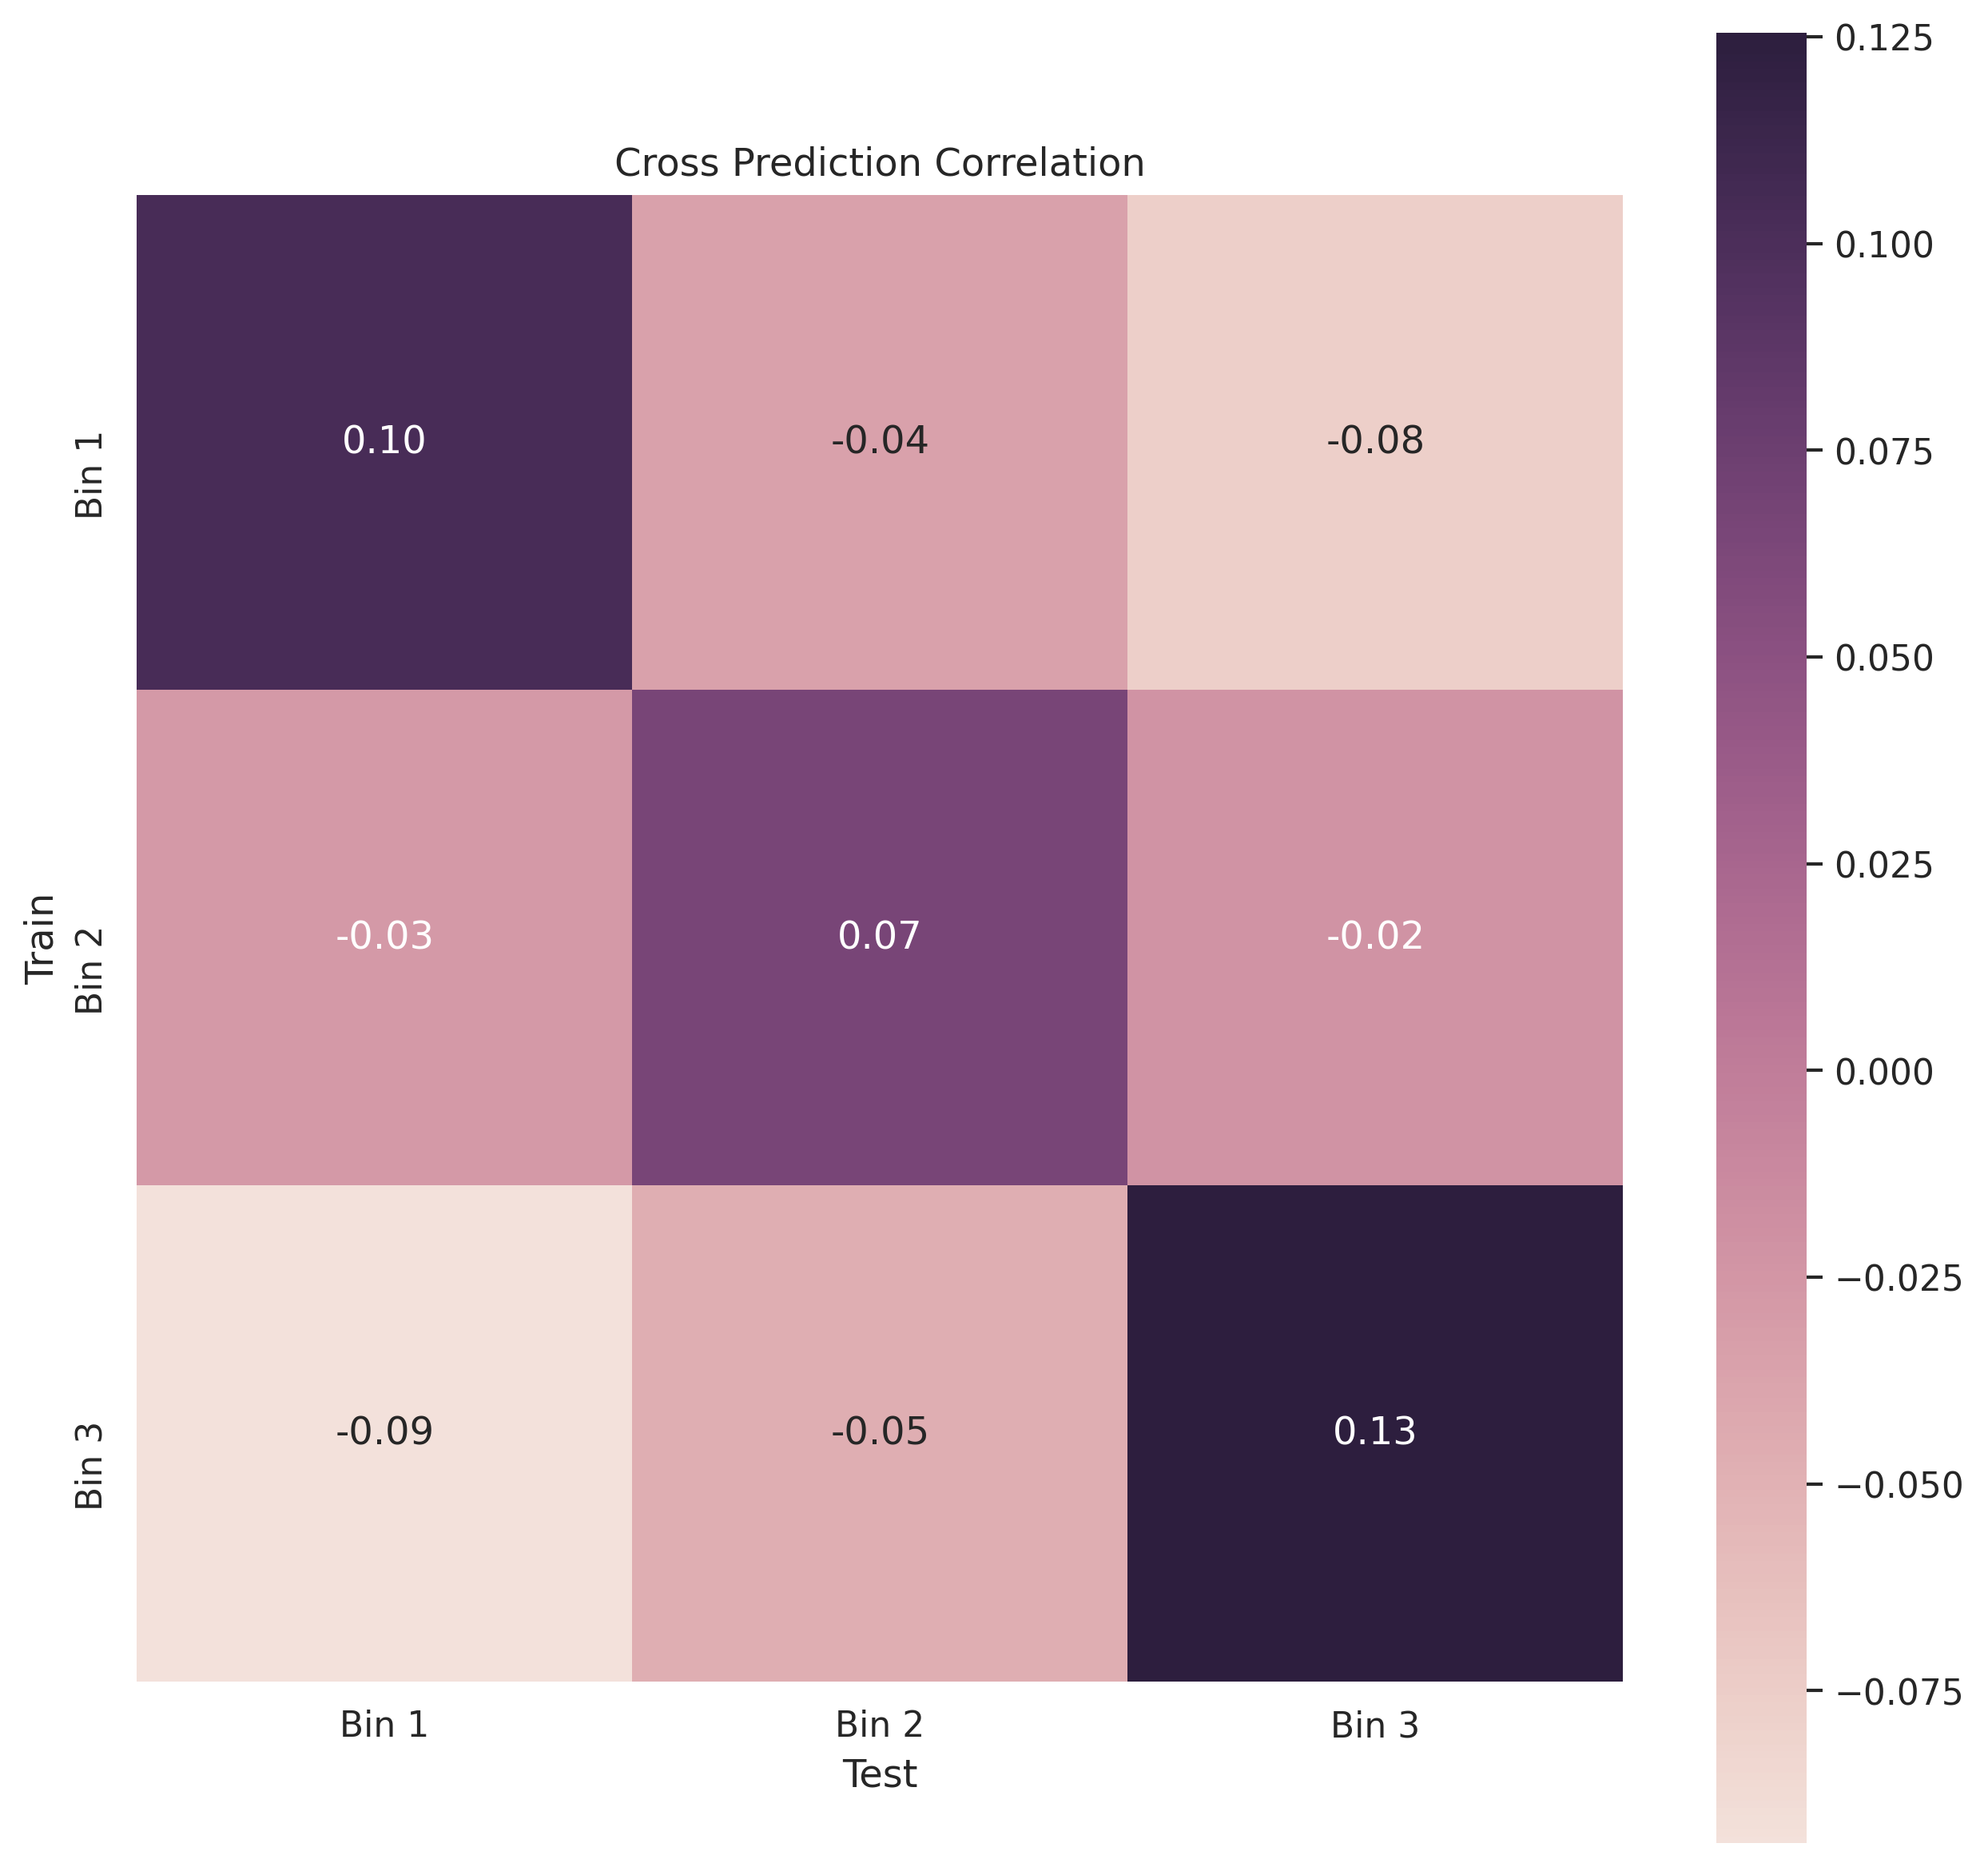

In [85]:
ax = sns.heatmap(df.pivot('Train', 'Test', 'Mean'), annot=True, fmt=".2f", cmap=sns.cubehelix_palette(as_cmap=True, light=.9), 
            square=True)
ax.set_title("Cross Prediction Correlation")
plt.show()